# Image Segmentation with U-Net

U-Net is a type of CNN designed for quick, precise image segmentation. We will use it to predict a label for every single pixel in an image - in this case, an image from a self-driving car dataset. This type of image classification is called semantic image segmentation. It's similar to object detection in that both ask the question: "What objects are in this image and where in the image are those objects located?," but where object detection labels objects with bounding boxes that may include pixels that aren't part of the object, semantic image segmentation allows you to predict a precise mask for each object in the image by labeling each pixel in the image with its corresponding class. The word “semantic” here refers to what's being shown, so for example the “Car” class is indicated below by the dark blue mask, and "Person" is indicated with a red mask:

<center><img src="images/carseg.png" style="width:500px;height:250;"></center>
<caption><center> <u><b>Figure 1</u></b>: Example of a segmented image <br> </center></caption>

Region-specific labeling is a pretty crucial consideration for self-driving cars, which require a pixel-perfect understanding of their environment so they can change lanes and avoid other cars, or any number of traffic obstacles that can put peoples' lives in danger. 

## Packages

In [5]:
import os
# import pandas as pd
import tensorflow as tf
import numpy as np
import imageio
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

In [6]:
%matplotlib inline

path = ''
image_path = os.path.join(path, '../datasets/CameraRGB/')
mask_path = os.path.join(path, '../datasets/CameraMask/')
image_list_orig = os.listdir(image_path)
image_list = [image_path+i for i in image_list_orig]
mask_list = [mask_path+i for i in image_list_orig]

### Check out the some of the unmasked and masked images from the dataset:

After you are done exploring, revert back to `N=2`. Otherwise the autograder will throw a `list index out of range` error.

C:\Users\darth\AppData\Local\Temp\ipykernel_19756\2127741555.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
C:\Users\darth\AppData\Local\Temp\ipykernel_19756\2127741555.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


Text(0.5, 1.0, 'Segmentation')

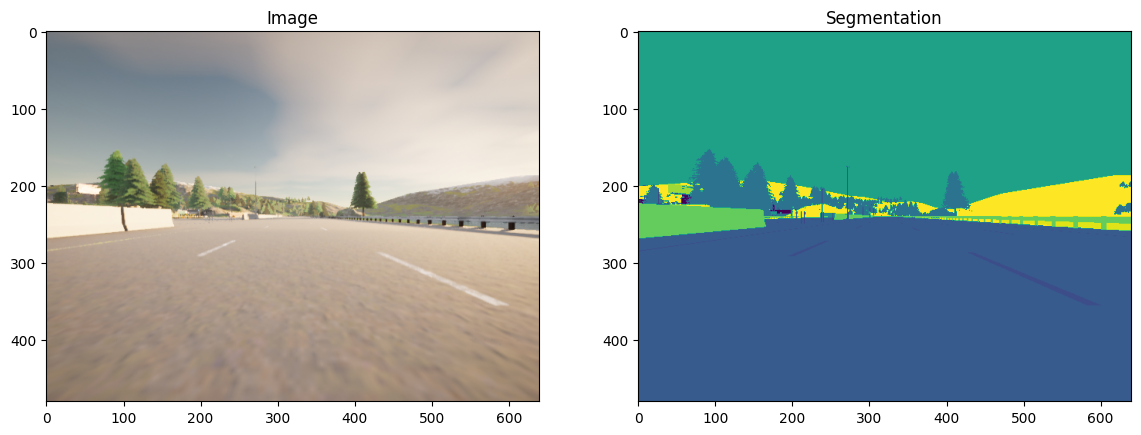

In [7]:
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

### Split Dataset into Unmasked and Masked Images

In [8]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'..\\datasets\\CameraRGB\\000026.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'..\\datasets\\CameraMask\\000026.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'..\\datasets\\CameraRGB\\000027.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'..\\datasets\\CameraMask\\000027.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'..\\datasets\\CameraRGB\\000028.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'..\\datasets\\CameraMask\\000028.png'>)


In [9]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'../datasets/CameraRGB/000026.png', shape=(), dtype=string)
tf.Tensor(b'../datasets/CameraMask/000026.png', shape=(), dtype=string)


### Preprocess Your Data

Normally, you normalize your image values by dividing them by `255`. This sets them between `0` and `1`. However, using `tf.image.convert_image_dtype` with `tf.float32` sets them between `0` and `1` for you, so there's no need to further divide them by `255`.

In [ ]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)